Detailed comments and explanations will be provided later

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install import_ipynb
!pip install moviepy
!pip install pickle5
!pip install -q mediapy
!pip install GPUtil
!pip install git+https://github.com/VLL-HD/FrEIA.git

In [ ]:
import visualize_new_code as viz
import L3net as l3
import networkx as nx
import numpy as np
import torch
import matplotlib.pyplot as plt
import Nets_new_code as nets
import utils_training_new_code as utils
import utils_data_new_code as utils_data
import importlib as ipb
import itertools
import torch_geometric as pyg
import sys
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import ipywidgets as widgets
import IPython.display as display
import mediapy as media
from FrEIA.framework import InputNode, OutputNode, Node, ReversibleGraphNet
from FrEIA.modules import GLOWCouplingBlock, PermuteRandom
import torch.nn as nn

# Loading.

In [ ]:
def get_training_input(name, version, edge_index, X_train, Y_train, X_test=None, Y_test=None):
    if name == 'real_CA_solar' or name == 'real_traffic_ATD':
        # Always have this L3net adj. included, but it is used only if 'L3net' is in 'version'
        if edge_index is not None:
            use_graph = True
            edge_index = edge_index.to(device)
        else:
            use_graph = False
        if name == 'real_CA_solar':
            edge_index_tmp = solar_loader.edge_index
            # In fact this should be unnecessary
            mean_0 = torch.Tensor([0.2485, 0.1790]).to(device)
            mean_1 = torch.Tensor([-0.7988, -0.5848]).to(device)
            mult1, mult2 = 16, 2
            data_name = f'CA_solar_{version}'
            edge_weight = torch.ones(solar_loader.edge_index.shape[1]).to(
                device)  # No edge weight
        else:
            edge_index_tmp = traffic_loader.edge_index
            mean_0 = torch.Tensor([1, -1]).to(device)
            mean_1 = torch.Tensor([-1, 1]).to(device)
            mult1, mult2 = 2, 2
            data_name = f'ATD_traffic_{version}'
            edge_weight = torch.ones(traffic_loader.edge_index.shape[1]).to(
                device)  # No edge weight
        A_ = pyg.utils.to_dense_adj(edge_index_tmp)[0].to(device)  # For L3net
        fix_W_g_b_g = True
        lr0 = 1e-4
        optim_classify = True
        scheduler = None
        mu, gamma = 0.1, 1
        resume_checkpoint = True
        X_train, Y_train = X_train.to(device), Y_train.to(device)
        X_test, Y_test = X_test.to(device), Y_test.to(device)
        num_viz, num_to_plot = 3, 300
    if name == 'simulation_graph':
        # Always have this L3net adj. included, but it is used only if 'L3net' is in 'version'
        edge_index_tmp = torch.tensor(
            [[0, 1, 1, 2, 0, 1, 2], [1, 0, 2, 1, 0, 1, 2]])
        A_ = pyg.utils.to_dense_adj(edge_index_tmp)[
            0].to(device)  # For L3net
        if edge_index is not None:
            use_graph = True
            edge_index = edge_index.to(device)
        else:
            use_graph = False
        mean_0 = torch.tensor([0, 1.5]).to(device)
        mean_1 = torch.tensor([0, -1.5]).to(device)
        mult1, mult2 = 1, 1
        fix_W_g_b_g = True
        lr0 = 5e-4
        optim_classify = True
        scheduler = None
        mu, gamma = 0.1, 1
        resume_checkpoint = True
        data_name = f'3node_graph_{version}'
        X_train, Y_train = X_train.to(device), Y_train.to(device)
        X_test, Y_test = X_test.to(device), Y_test.to(device)
        num_viz, num_to_plot = 2, 100
        edge_weight = torch.tensor([1, 1, 1, 1, 1, 1, 1]).float().to(
            device)  # No edge weight
    if name == 'simulation_GP_graph':
        # Always have this L3net adj. included, but it is used only if 'L3net' is in 'version'
        edge_index_tmp = data_generator.edge_index
        A_ = pyg.utils.to_dense_adj(edge_index_tmp)[
            0].to(device)  # For L3net
        if edge_index is not None:
            use_graph = True
            edge_index = edge_index.to(device)
        else:
            use_graph = False
        mean_0 = torch.tensor([0.]).to(device)
        mean_1 = torch.tensor([-5.]).to(device)
        mult1, mult2 = 1, 1
        fix_W_g_b_g = True
        lr0 = 5e-4
        optim_classify = False
        scheduler = None
        mu, gamma = 0.1, 1
        resume_checkpoint = True
        data_name = f'GP_graph_{version}'
        X_train, Y_train = X_train.to(device), Y_train.to(device)
        X_test, Y_test = X_test.to(device), Y_test.to(device)
        num_viz, num_to_plot = 2, 100
        edge_weight = torch.ones(edge_index_tmp.shape[1]).to(
            device)  # No edge weight
    if name == 'simulation_non_graph':
        edge_index = None
        A_ = None
        use_graph = False
        mean_0 = X_train[Y_train == 0].mean(axis=0).to(device)
        mean_1 = X_train[Y_train == 1].mean(axis=0).to(device)
        mult1, mult2 = 4, 4
        fix_W_g_b_g = True
        lr0 = 1e-3
        optim_classify = False
        scheduler = None
        mu, gamma = 1, 1
        resume_checkpoint = True
        data_name = f'two_moon_{version}'
        X_train, Y_train = X_train.to(device), Y_train.to(device)
        num_viz, num_to_plot = 1, 100
        edge_weight = None
    if name == 'simulation_8_gaussian':
        edge_index = None
        A_ = None
        use_graph = False
        mean_0 = X_train[Y_train == 0].mean(axis=0).to(device)
        mean_1 = X_train[Y_train == 1].mean(axis=0).to(device)
        mean_2 = X_train[Y_train == 2].mean(axis=0).to(device)
        mean_3 = X_train[Y_train == 3].mean(axis=0).to(device)
        mult1, mult2, mult3, mult4 = 1, 1, 1, 1
        fix_W_g_b_g = True
        lr0 = 5e-4 # Was 1e-3 without decay, and a blow up at epoch 200, but get fairly close to the actual
        optim_classify = False
        scheduler = None
        mu, gamma = 1, 1
        resume_checkpoint = True
        data_name = f'8_gaussian_{version}'
        X_train, Y_train = X_train.to(device), Y_train.to(device)
        X_test, Y_test = X_test.to(device), Y_test.to(device)
        num_viz, num_to_plot = 1, Ntot
        edge_weight = None
    torch.manual_seed(1103)
    model_graph = nets.InvResNet(C, output_dim, nblocks=nblocks,
                                 model_args=model_args, graph=use_graph, dim_inc=False, version=version, A_=A_).to(device)
    # Because for FC, sometimes we flatten the feature so C > 2
    gen_dim = min(2, C)
    gen_net = nets.SmallGenNet(Y_dim, gen_dim).to(
        device)  # Always flow in R^2 now
    with torch.no_grad():
        if name != 'simulation_8_gaussian':
            gen_net.fc.weight = torch.nn.Parameter(
                torch.transpose(torch.vstack([mult1*mean_0, mult2*mean_1]), 0, 1).to(device))
        else:
            gen_net.fc.weight = torch.nn.Parameter(
                torch.transpose(torch.vstack([mult1*mean_0, mult2*mean_1, mult3*mean_2, mult4*mean_3]), 0, 1).to(device))
        gen_net.fc.bias = torch.nn.Parameter(
            torch.zeros(gen_dim).to(device))
    if fix_W_g_b_g:
        for param in gen_net.parameters():
            param.requires_grad = False
    params = list(model_graph.parameters()) + list(gen_net.parameters())
    optimizer = torch.optim.Adam(params, lr=lr0, weight_decay=5e-4)
    models = [model_graph, gen_net]
    mod_args = [model_args[1], nblocks]
    train_args = [optimizer, optim_classify, mu, gamma,
                  epochs, scheduler, resume_checkpoint]
    data_args = [edge_index, edge_weight,
                 batch_size, data_name, num_viz, num_to_plot]
    return [models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test]


# A. Solar

## Get data

#1/#0 in training data is 0.31002275176625554
#1/#0 in test data is 0.38257575757575757
30 directed edges initially
38 undirected edges after insertion


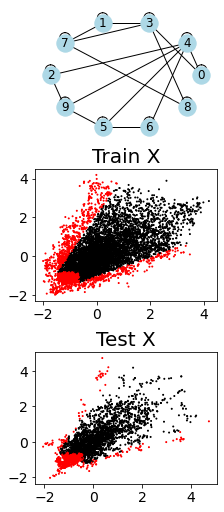

In [ ]:
for _ in ['hyper-parameters']:
    # Define hyper-parameters
    # NOTE: V max is 10
    para_dict = {'CA': [10, 2, 150, 300, 1]}
    city = 'CA'
    V, C, batch_size, epochs, F_out = para_dict[city]
    output_dim, Y_dim, nblocks = 1, 2, 40
    model_args = [0.9, 64, 3]
    solar_loader = utils_data.solar_data(num_obs_per_day=2, city=city)
    solar_loader.get_solar()
    # # If we want to plot
    solar_loader.plot_solar()
    X_train, Y_train, X_test, Y_test, edge_index = solar_loader.X_train, solar_loader.Y_train, solar_loader.X_test, solar_loader.Y_test, solar_loader.edge_index

## iGNN-Cheb+FC

In [ ]:
for _ in ['hyper-parameters']:
    # Define hyper-parameters
    # NOTE: V max is 10
    para_dict = {'CA': [10, 2, 150, 300, 1]}
    city = 'CA'
    V, C, batch_size, epochs, F_out = para_dict[city]
    output_dim, Y_dim, nblocks = 1, 2, 40
    model_args = [0.9, 64, 3]
    solar_loader = utils_data.solar_data(num_obs_per_day=2, city=city)
    solar_loader.get_solar()
    # # If we want to plot
    solar_loader.plot_solar()
    X_train, Y_train, X_test, Y_test, edge_index = solar_loader.X_train, solar_loader.Y_train, solar_loader.X_test, solar_loader.Y_test, solar_loader.edge_index

In [ ]:
for _ in ['Training_IRresNet_GNN+FC']:
    edge_index = solar_loader.edge_index
    models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test = get_training_input(
        'real_CA_solar', 'one_Cheb_two_FC', edge_index, X_train, Y_train, X_test, Y_test)
    train_args[-1] = True  # If resume_training
    real_data_trainer = utils.IResNet_training_on_graph(
        models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
    # real_data_trainer.all_together()

Checking generation at 
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0') with 679 out of 1094 data
Invert 679 samples took 3.8488068480000948 secs
1st Var to Last Var, lightest to darkest: tensor([0.0000, 0.2050, 0.4057, 0.4371, 0.4954, 0.6003, 0.5392, 0.7668, 1.0000,
        1.0000])


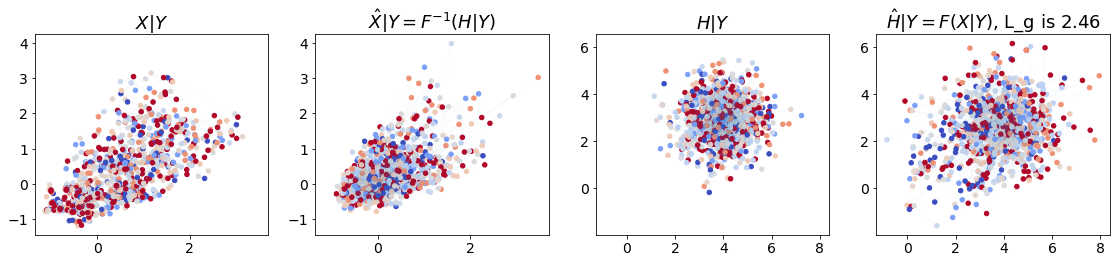

Checking generation at 
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0') with 144 out of 1094 data
Invert 144 samples took 2.859785680000641 secs
1st Var to Last Var, lightest to darkest: tensor([0.0000, 0.0434, 0.0893, 0.0893, 0.1430, 0.5534, 0.6815, 0.6518, 0.6774,
        1.0000])


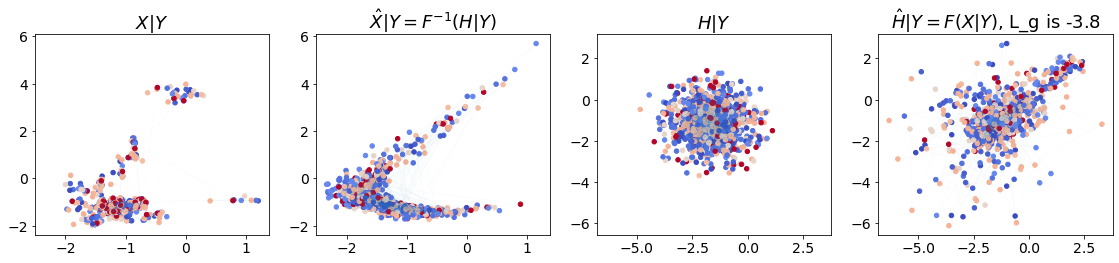

Checking generation at 
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], device='cuda:0') with 22 out of 1094 data
Invert 22 samples took 2.748273844999858 secs
1st Var to Last Var, lightest to darkest: tensor([0.0000, 0.1215, 0.1215, 0.1236, 0.1944, 0.2487, 0.2827, 0.3484, 0.3934,
        1.0000])


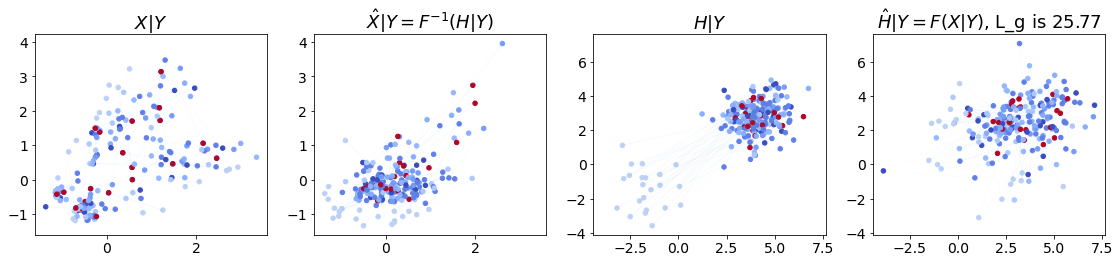

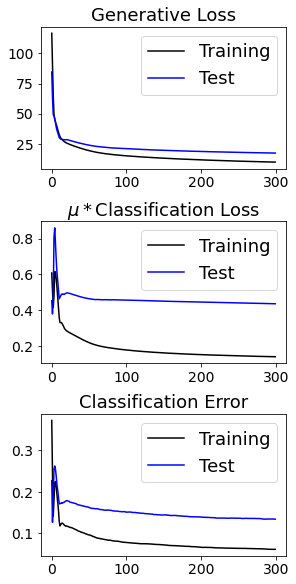

In [ ]:
for _ in ['Load_and_visualize']:
    # Directly load from saved checkpoint for visualization
    train_args[-1] = True  # If resume_training
    real_data_trainer = utils.IResNet_training_on_graph(
        models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
    real_data_trainer.cpu_load = True
    real_data_trainer.load_from_checkpoint()  # Load previous models from file
    real_data_trainer.get_H_cond_Y()  # Get H|Y
    real_data_trainer.viz = True  # If report transport cost
    real_data_trainer.final_viz = True
    real_data_trainer.viz_generation()
    real_data_trainer.viz_losses()
    # Unique_Y, counts_Y = torch.unique(
    #     real_data_trainer.Y_train, return_counts=True, dim=0)
    # counts_Y, idx = torch.sort(counts_Y, descending=True)
    # Y_rows = Unique_Y[idx]
    # Y_row = Y_rows[2]
    # print(f'Flow gif at {Y_row}')
    # real_data_trainer.get_GIF(Y_row)
    # viz.trajectory_to_gif(real_data_trainer)
    # real_data_trainer.get_GIF(Y_row, from_X_to_H=True)
    # viz.trajectory_to_gif(real_data_trainer)

In [ ]:
# View images one by one, but work after refreshing
real_data_trainer.cpu_load = True
real_data_trainer.load_from_checkpoint()  # Load previous models from file
fileXtoH = f'{real_data_trainer.path}/trajectory_epoch{real_data_trainer.epoch}_XtoH.mp4'
fileHtoX = f'{real_data_trainer.path}/trajectory_epoch{real_data_trainer.epoch}_HtoX.mp4'
print(fileXtoH)
print(fileHtoX)
Unique_Y, counts_Y = torch.unique(
    real_data_trainer.Y_train, return_counts=True, dim=0)
counts_Y, idx = torch.sort(counts_Y, descending=True)
Y_rows = Unique_Y[idx]
Y_row = Y_rows[2]
print(f'Flow Train gif at {Y_row}')
flows = {'Flow_XtoH': media.read_video(fileXtoH), 'Flow_HtoX': media.read_video(fileHtoX)}
media.show_videos(flows, width = 400, height = 650)

## CINN-MMD or CINN-Nflow

In [ ]:
for _ in ['Training_CINN']:
    edge_index = None
    models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test = get_training_input(
        'real_CA_solar', 'three_FC', edge_index, X_train, Y_train, X_test, Y_test)
    # for CINN_obj in ['', '_Nflow']:
    for CINN_obj in ['']:
        ########## CINN here ##########
        if 'Nflow' in CINN_obj:
            dim, nblocks, clamp_val, lr = 64, 40, 0.25, 1e-4
        else:
            dim, nblocks, clamp_val, lr = 64, 40, 0.25, 1e-4
        def subnet_fc(c_in, c_out):
            return nn.Sequential(nn.Linear(c_in, dim), nn.ELU(), nn.Linear(dim,  dim), nn.ELU(),
                                nn.Linear(dim,  c_out))
        ndim_x = V*C
        ndim_y = V*Y_dim
        ndim_tot = ndim_x+ndim_y+V*4  # 4 dimension per node for padding
        nodes = [InputNode(ndim_tot, name='input')]
        for k in range(nblocks):
            nodes.append(Node(nodes[-1],
                              GLOWCouplingBlock,
                              {'subnet_constructor': subnet_fc, 'clamp': clamp_val},
                              name=F'coupling_{k}'))
            nodes.append(Node(nodes[-1],
                              PermuteRandom,
                              {'seed': k},
                              name=F'permute_{k}'))
        nodes.append(OutputNode(nodes[-1], name='output'))
        model = ReversibleGraphNet(nodes, verbose=False).to(device)
        l2_reg = 2e-5
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.8, 0.9),
                                    eps=1e-6, weight_decay=l2_reg)
        models[0] = [model]
        train_args[0] = optimizer
        ########## CINN end ##########
        train_args[-1] = True  # If resume_training
        train_args[-3] = 500  # Num epochs
        real_data_trainer = utils.IResNet_training_on_graph(
            models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
        real_data_trainer.CINN_obj = CINN_obj
        real_data_trainer.data_name += real_data_trainer.CINN_obj
        real_data_trainer.ndim_x, real_data_trainer.ndim_y, real_data_trainer.ndim_tot = ndim_x, ndim_y, ndim_tot
        # real_data_trainer.all_together_competitor()

In [ ]:
for _ in ['Load_and_visualize']:
    epoch_ls = []
    for CINN_obj in ['', '_Nflow']:
        real_data_trainer = utils.IResNet_training_on_graph(
            models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
        real_data_trainer.CINN_obj = CINN_obj  # Nflow or '', which denotes MMD
        real_data_trainer.data_name += real_data_trainer.CINN_obj
        real_data_trainer.ndim_x, real_data_trainer.ndim_y, real_data_trainer.ndim_tot = ndim_x, ndim_y, ndim_tot
        real_data_trainer.resume_checkpoint = True
        real_data_trainer.final_viz = True
        real_data_trainer.cpu_load = True
        real_data_trainer.load_from_checkpoint_competitors()
        epoch = real_data_trainer.epoch + 1
        epoch_ls.append(epoch)
        real_data_trainer.viz_generation_competitors()
        real_data_trainer.viz_losses_competitors()
        print('########################################################')

""

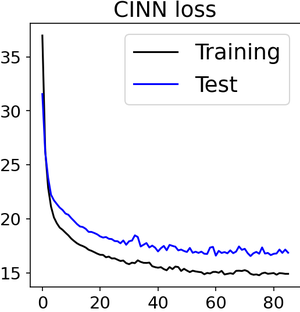

At Train CA Solar top 1,At Train CA Solar top 2,At Train CA Solar top 3

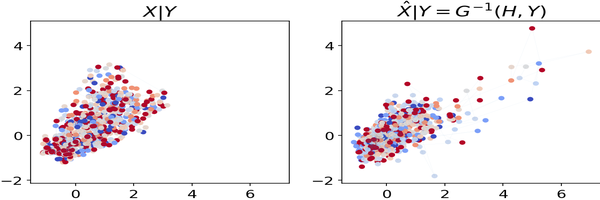
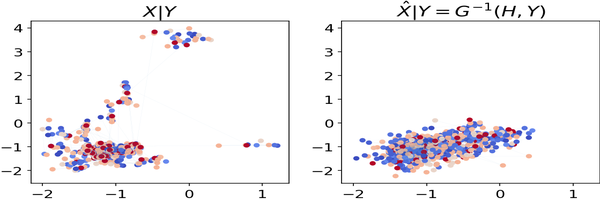
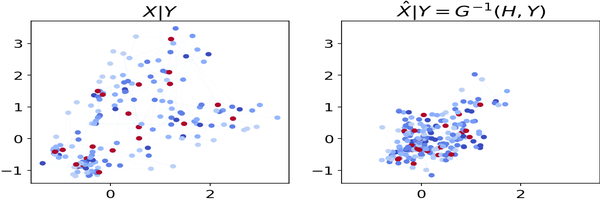

########################################################


""

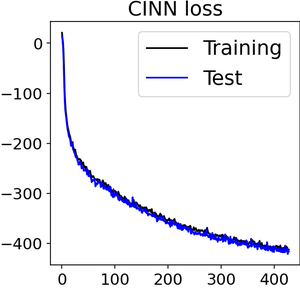

At Train CA Solar top 1,At Train CA Solar top 2,At Train CA Solar top 3

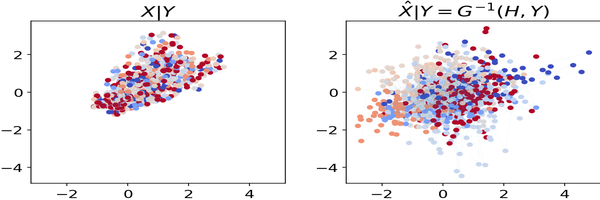
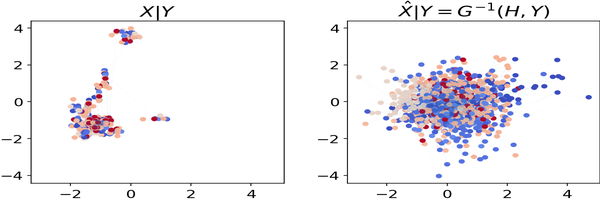
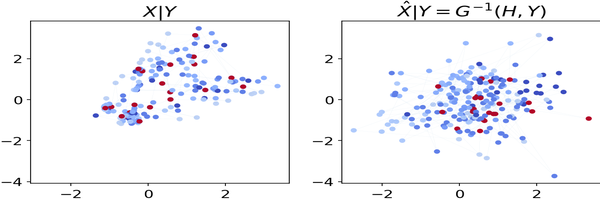

########################################################


In [ ]:
# View images one by one, but work after refreshing
Num = range(1,4)
for i, CINN_obj in enumerate(['', '_Nflow']):
    epoch = epoch_ls[i]
    version, method = 'three_FC', 'CINN'
    media.show_image(media.read_image(f'CA_solar_{version}{CINN_obj}_{method}/Losses_epoch{epoch}.png'),width=300)
    loss_images = {f'At Train CA Solar top {i}': media.read_image(f'CA_solar_{version}{CINN_obj}_{method}/Generation_train_epoch{epoch}_top{i}_occurrences.png') for i in Num}
    media.show_images(loss_images,height=200,width=600, columns = 3)
    print('########################################################')

## CGAN 

Note, loss with Wasserstain loss a bit strange, so we use the old min-max loss

In [ ]:
version = 'one_Cheb_two_FC'
edge_index = solar_loader.edge_index
edge_index_tmp = solar_loader.edge_index
models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test = get_training_input(
    'real_CA_solar', version, edge_index, X_train, Y_train, X_test, Y_test)
########## CGAN HERE ##########
dim = 64
A_, graph = None, True
if 'L3' in version or 'Cheb' not in version:
    A_ = pyg.utils.to_dense_adj(edge_index_tmp)[0].to(device)
    graph = False
nblocks = 20
net_D = nets.CGAN_net(C+Y_dim, dim, Y_dim, nblocks, True, graph,
                      version=version, A_=A_).to(device)
nblocks = 40
net_G = nets.CGAN_net(C+Y_dim, dim, Y_dim, nblocks, False, graph, version=version, A_=A_).to(device)
optimizer_D = torch.optim.Adam(net_D.parameters(), lr=1e-4, weight_decay = 0.5)
optimizer_G = torch.optim.Adam(net_G.parameters(), lr=5e-4, weight_decay = 0.5)
models[0] = [net_D, net_G]
train_args[0] = [optimizer_D, optimizer_G]
########## CGAN END ##########
train_args[-1] = True  # If resume_training
train_args[-3] = 500  # Num epochs
data_args[-3] = f'CA_solar_{version}'
real_data_trainer = utils.IResNet_training_on_graph(
    models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
real_data_trainer.stop_criterion = 1e-6
# real_data_trainer.all_together_competitor()

In [ ]:
real_data_trainer = utils.IResNet_training_on_graph(
        models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
real_data_trainer.resume_checkpoint = True
real_data_trainer.load_from_checkpoint_competitors()
real_data_trainer.final_viz = True
epoch = real_data_trainer.epoch + 1
real_data_trainer.viz_generation_competitors()
real_data_trainer.viz_losses_competitors()
real_data_trainer.viz_generation_competitors(viz_train=False)

""

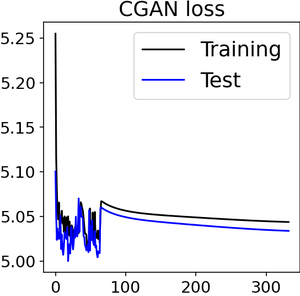

In [ ]:
# View images one by one, but work after refreshing
Num = range(1,4)
version, method = 'one_Cheb_two_FC', 'CGAN'
media.show_image(media.read_image(f'CA_solar_{version}_{method}/Losses_epoch{epoch}.png'),width=300)
# loss_images = {f'At Train CA Solar top {i}': media.read_image(f'CA_solar_{version}_{method}/Generation_train_epoch{epoch}_top{i}_occurrences.png') for i in Num}
# media.show_images(loss_images,height=200,width=600, columns = 3)

## (Appendix) iGNN-L3net+FC

In [ ]:
for _ in ['Training_IRresNet_L3']:
    edge_index = None
    models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test = get_training_input(
        'real_CA_solar', 'one_L3_two_FC', edge_index, X_train, Y_train, X_test, Y_test)
    train_args[-1] = True  # If resume_training
    real_data_trainer = utils.IResNet_training_on_graph(
        models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
    # real_data_trainer.all_together()

In [ ]:
print('Bases orders are')
real_data_trainer.model.blocks[0].bottleneck_block[1].order_list # Check how many bases & their hops.

Bases orders are


[1, 2]

Checking generation at 
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0') with 679 out of 1094 data
Invert 679 samples took 0.9341980530000455 secs
1st Var to Last Var, lightest to darkest: [0.         0.4839063  0.4945483  0.5514728  0.58540916 0.67972696
 0.51676035 0.82697767 1.         1.        ]


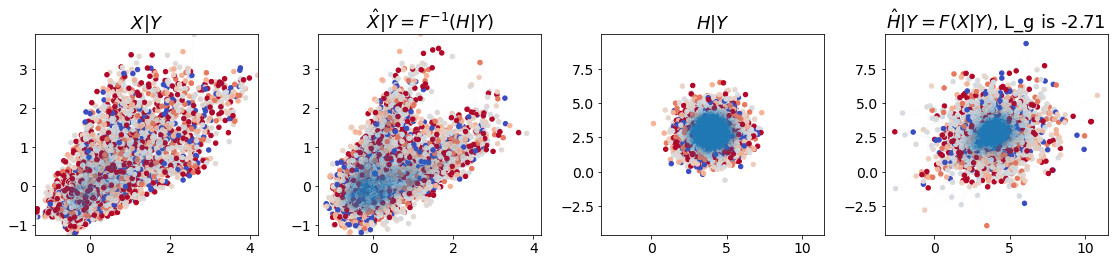

Checking generation at 
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0') with 144 out of 1094 data
Invert 144 samples took 0.9263844980000613 secs
1st Var to Last Var, lightest to darkest: [0.         0.34008634 0.34008634 0.42308033 0.4890498  0.5585649
 0.59150887 0.63267285 0.5557706  1.        ]


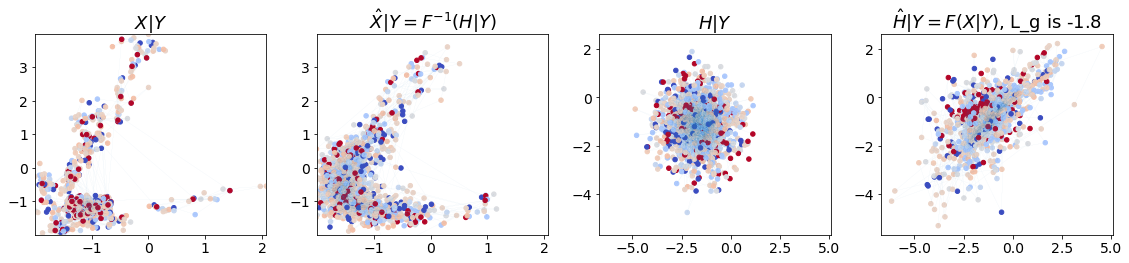

Checking generation at 
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], device='cuda:0') with 22 out of 1094 data
Invert 22 samples took 0.9202141079999819 secs
1st Var to Last Var, lightest to darkest: [0.         0.12150586 0.12150586 0.12361913 0.19436401 0.2486909
 0.28267258 0.34836468 0.39340046 1.        ]


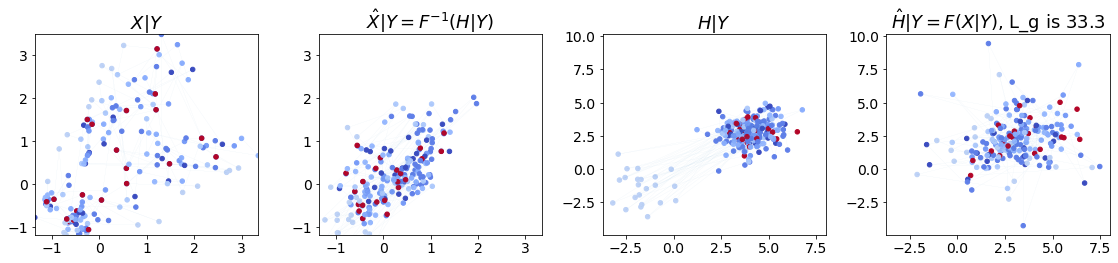

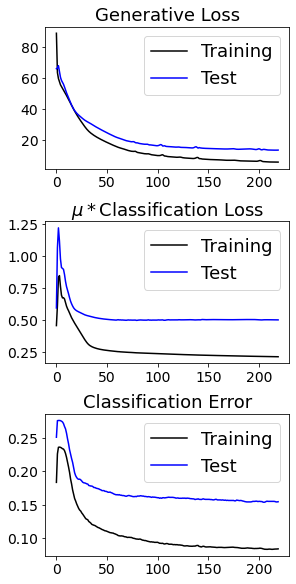

In [ ]:
for _ in ['Load_and_visualize']:
    # Directly load from saved checkpoint for visualization
    train_args[-1] = True  # If resume_training
    real_data_trainer = utils.IResNet_training_on_graph(
        models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
    real_data_trainer.cpu_load = True
    real_data_trainer.load_from_checkpoint()  # Load previous models from file
    real_data_trainer.get_H_cond_Y()  # Get H|Y
    real_data_trainer.viz = True  # If report transport cost
    real_data_trainer.final_viz = True
    real_data_trainer.plot_sub = False # To plot X, \hat X, H, \hat H
    real_data_trainer.viz_generation()
    real_data_trainer.viz_losses()
    # Unique_Y, counts_Y = torch.unique(
    #     real_data_trainer.Y_train, return_counts=True, dim=0)
    # counts_Y, idx = torch.sort(counts_Y, descending=True)
    # Y_rows = Unique_Y[idx]
    # Y_row = Y_rows[2]
    # print(f'Flow gif at {Y_row}')
    # real_data_trainer.get_GIF(Y_row)
    # viz.trajectory_to_gif(real_data_trainer)
    # real_data_trainer.get_GIF(Y_row, from_X_to_H=True)
    # viz.trajectory_to_gif(real_data_trainer)

In [ ]:
# View images one by one, but work after refreshing
real_data_trainer.cpu_load = True
real_data_trainer.load_from_checkpoint()  # Load previous models from file
fileXtoH = f'{real_data_trainer.path}/trajectory_epoch{real_data_trainer.epoch}_XtoH.mp4'
fileHtoX = f'{real_data_trainer.path}/trajectory_epoch{real_data_trainer.epoch}_HtoX.mp4'
print(fileXtoH)
print(fileHtoX)
Unique_Y, counts_Y = torch.unique(
    real_data_trainer.Y_train, return_counts=True, dim=0)
counts_Y, idx = torch.sort(counts_Y, descending=True)
Y_rows = Unique_Y[idx]
Y_row = Y_rows[2]
print(f'Flow Train gif at {Y_row}')
flows = {'Flow_XtoH': media.read_video(fileXtoH), 'Flow_HtoX': media.read_video(fileHtoX)}
media.show_videos(flows, width = 400, height = 650)

## (Appendix) iGNN-FC

In [ ]:
for _ in ['Training_IRresNet_FC']:
    V, C = 1, 20
    X_train = X_train.reshape(X_train.shape[0], V, C)
    X_test = X_test.reshape(X_test.shape[0], V, C)
    edge_index = None
    models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test = get_training_input(
        'real_CA_solar', 'three_FC', edge_index, X_train, Y_train, X_test, Y_test)
    train_args[-1] = True  # If resume_training
    real_data_trainer = utils.IResNet_training_on_graph(
        models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
    # real_data_trainer.all_together()

Checking generation at 
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0') with 679 out of 1094 data
Invert 679 samples took 0.6305217110000285 secs
1st Var to Last Var, lightest to darkest: [0.         0.4839063  0.4945483  0.5514728  0.58540916 0.67972696
 0.51676035 0.82697767 1.         1.        ]


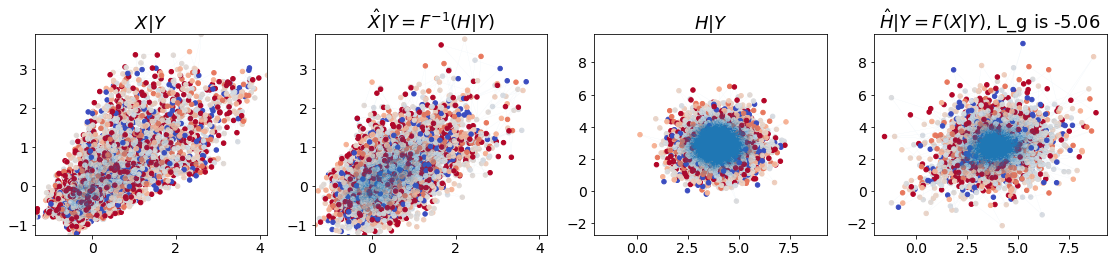

Checking generation at 
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0') with 144 out of 1094 data
Invert 144 samples took 0.3815537130000166 secs
1st Var to Last Var, lightest to darkest: [0.         0.34008634 0.34008634 0.42308033 0.4890498  0.5585649
 0.59150887 0.63267285 0.5557706  1.        ]


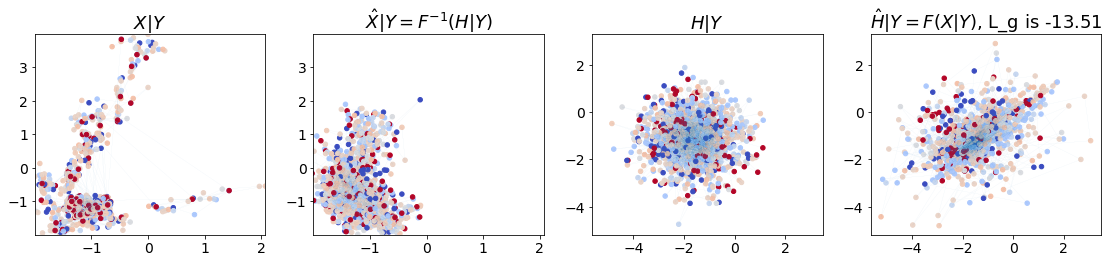

Checking generation at 
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], device='cuda:0') with 22 out of 1094 data
Invert 22 samples took 0.3859131780000098 secs
1st Var to Last Var, lightest to darkest: [0.         0.12150586 0.12150586 0.12361913 0.19436401 0.2486909
 0.28267258 0.34836468 0.39340046 1.        ]


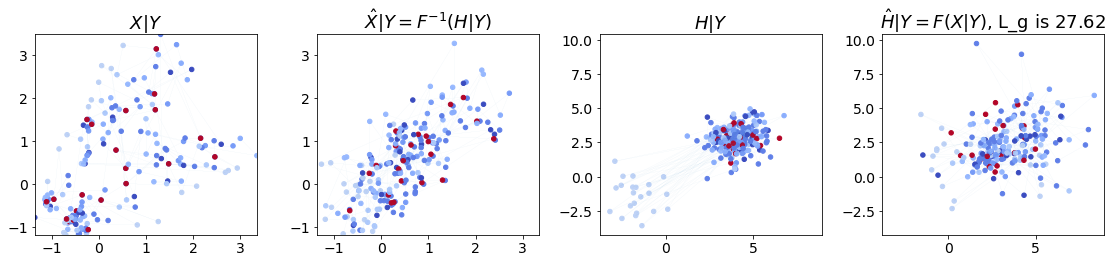

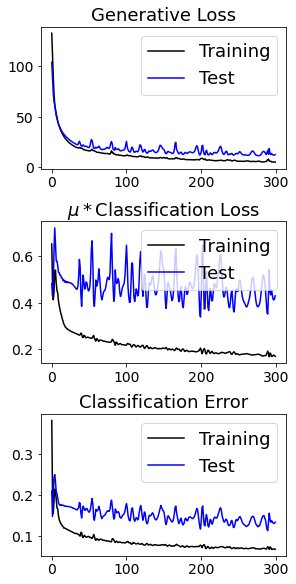

In [ ]:
for _ in ['Load_and_visualize']:
    # Directly load from saved checkpoint for visualization
    train_args[-1] = True  # If resume_training
    real_data_trainer = utils.IResNet_training_on_graph(
        models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
    real_data_trainer.cpu_load = True
    real_data_trainer.load_from_checkpoint()  # Load previous models from file
    real_data_trainer.get_H_cond_Y()  # Get H|Y
    real_data_trainer.viz = True  # If report transport cost
    real_data_trainer.final_viz = True
    real_data_trainer.plot_sub = False # To plot X, \hat X, H, \hat H
    real_data_trainer.viz_generation()
    real_data_trainer.viz_losses()
    # Unique_Y, counts_Y = torch.unique(
    #     real_data_trainer.Y_train, return_counts=True, dim=0)
    # counts_Y, idx = torch.sort(counts_Y, descending=True)
    # Y_rows = Unique_Y[idx]
    # Y_row = Y_rows[2]
    # print(f'Flow gif at {Y_row}')
    # real_data_trainer.get_GIF(Y_row)
    # viz.trajectory_to_gif(real_data_trainer)
    # real_data_trainer.get_GIF(Y_row, from_X_to_H=True)
    # viz.trajectory_to_gif(real_data_trainer)

In [ ]:
# View images one by one, but work after refreshing
real_data_trainer.cpu_load = True
real_data_trainer.load_from_checkpoint()  # Load previous models from file
fileXtoH = f'{real_data_trainer.path}/trajectory_epoch{real_data_trainer.epoch}_XtoH.mp4'
fileHtoX = f'{real_data_trainer.path}/trajectory_epoch{real_data_trainer.epoch}_HtoX.mp4'
print(fileXtoH)
print(fileHtoX)
Unique_Y, counts_Y = torch.unique(
    real_data_trainer.Y_train, return_counts=True, dim=0)
counts_Y, idx = torch.sort(counts_Y, descending=True)
Y_rows = Unique_Y[idx]
Y_row = Y_rows[2]
print(f'Flow Train gif at {Y_row}')
flows = {'Flow_XtoH': media.read_video(fileXtoH), 'Flow_HtoX': media.read_video(fileHtoX)}
media.show_videos(flows, width = 400, height = 650)

# B. Traffic

## Get data

In [ ]:
# %xmode Plain
# %pdb on

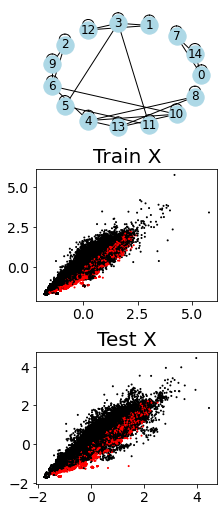

In [ ]:
for _ in ['hyper-parameters']:
    V, C, batch_size, epochs, F_out = 15, 2, 200, 300, 1
    output_dim, Y_dim, nblocks = 1, 2, 40
    model_args = [0.9, 64, 3] 
    traffic_loader = utils_data.trffic_data(d=C)
    traffic_loader.get_traffic_train_test(sub=True)
    # Only select a subset for training (e.g., fix Y)
    Unique_Y, counts_Y = torch.unique(traffic_loader.Y_train, return_counts=True, dim=0)
    counts_Y, idx = torch.sort(counts_Y, descending=True)
    Unique_Y = Unique_Y[idx]
    Y_rows = None
    # Y_rows = [Unique_Y[1]]
    traffic_loader.select_Y(Y_rows,train = True)
    traffic_loader.select_Y(Y_rows,train = False)
    X_train, X_test, Y_train, Y_test, edge_index = traffic_loader.X_train_sub, traffic_loader.X_test_sub, traffic_loader.Y_train_sub, traffic_loader.Y_test_sub, traffic_loader.edge_index
    traffic_loader.plot_traffic()

In [ ]:
# See the ratio between one and zero per node.
if Y_rows is None:
    print(torch.unique(Y_train.flatten(), return_counts=True, dim=0))
    print(torch.unique(Y_test.flatten(), return_counts=True, dim=0))
if Y_rows is not None:
    print(torch.unique(Y_train, return_counts=True, dim=0))
    print(torch.unique(Y_test, return_counts=True, dim=0))
_, counts_train= torch.unique(Y_train.flatten(), return_counts=True, dim=0)

(tensor([0., 1.]), tensor([38500,  7550]))
(tensor([0., 1.]), tensor([16410,  3390]))


## iGNN

In [ ]:
for _ in ['hyper-parameters']:
    V, C, batch_size, epochs, F_out = 15, 2, 200, 300, 1
    output_dim, Y_dim, nblocks = 1, 2, 40
    model_args = [0.9, 64, 3] 
    traffic_loader = utils_data.trffic_data(d=C)
    traffic_loader.get_traffic_train_test(sub=True)
    # Only select a subset for training (e.g., fix Y)
    Unique_Y, counts_Y = torch.unique(traffic_loader.Y_train, return_counts=True, dim=0)
    counts_Y, idx = torch.sort(counts_Y, descending=True)
    Unique_Y = Unique_Y[idx]
    Y_rows = None
    # Y_rows = [Unique_Y[1]]
    traffic_loader.select_Y(Y_rows,train = True)
    traffic_loader.select_Y(Y_rows,train = False)
    X_train, X_test, Y_train, Y_test, edge_index = traffic_loader.X_train_sub, traffic_loader.X_test_sub, traffic_loader.Y_train_sub, traffic_loader.Y_test_sub, traffic_loader.edge_index

In [ ]:
# # If Cheb, uncomment line below
# edge_index = traffic_loader.edge_index
# If FC or L3net, uncomment lines below
edge_index = None
V, C = 1, 30
X_train = X_train.reshape(X_train.shape[0], V, C)
X_test = X_test.reshape(X_test.shape[0], V, C)
#
version = 'four_FC'
models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test = get_training_input(
    'real_traffic_ATD', version, edge_index, X_train, Y_train, X_test, Y_test)
train_args[-1] = True  # If resume_training
# # If train on X|Y, uncomment and possibly change some argument below
# data_args[3] = f'ATD_traffic_{version}_fixY_top{i}'
# data_args[-2] = 1 # How many Y to visualize
# data_args[2] = 50 # Batch size. For less frequent Y, make this smaller
# #
real_data_trainer = utils.IResNet_training_on_graph(
    models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
if len(counts_train) > 1:
    # So loss for class 0 and 1 are balanced
    real_data_trainer.mu0 = (1-counts_train[0]/counts_train.sum()).item() 
    real_data_trainer.mu1 = 1-real_data_trainer.mu0 
real_data_trainer.stop_criterion = 1e-5
# real_data_trainer.all_together()

In [ ]:
for _ in ['Load_and_visualize']:
    # Directly load from saved checkpoint for visualization
    train_args[-1] = True  # If resume_training
    real_data_trainer = utils.IResNet_training_on_graph(
        models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
    real_data_trainer.cpu_load = True
    real_data_trainer.load_from_checkpoint()  # Load previous models from file
    real_data_trainer.get_H_cond_Y()  # Get H|Y
    real_data_trainer.viz = True  # If report transport cost
    real_data_trainer.final_viz = True
    real_data_trainer.viz_generation()
    real_data_trainer.viz_losses()
    # Unique_Y, counts_Y = torch.unique(
    #     real_data_trainer.Y_train, return_counts=True, dim=0)
    # counts_Y, idx = torch.sort(counts_Y, descending=True)
    # Y_rows = Unique_Y[idx]
    # Y_row = Y_rows[2]
    # print(f'Flow gif at {Y_row}')
    # real_data_trainer.get_GIF(Y_row)
    # viz.trajectory_to_gif(real_data_trainer)
    # real_data_trainer.get_GIF(Y_row, from_X_to_H=True)
    # viz.trajectory_to_gif(real_data_trainer)

Loss

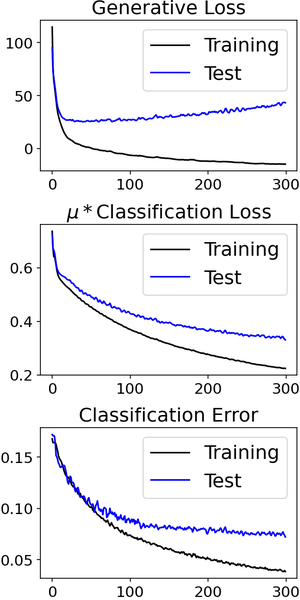

Train Generation for top 1,Train Generation for top 2,Train Generation for top 3

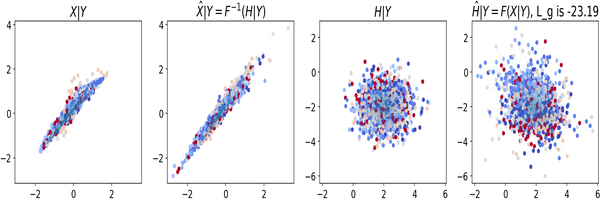
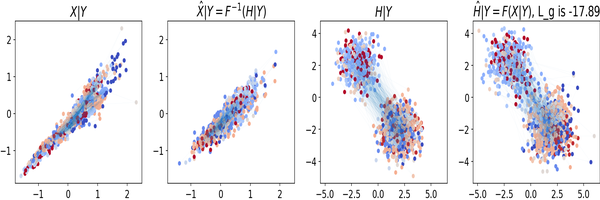
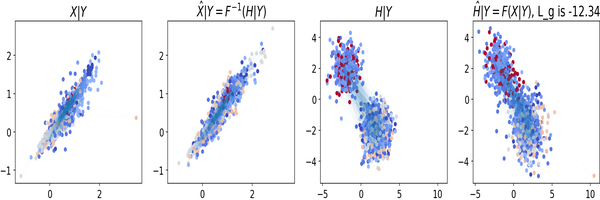

Test Generation for top 1,Test Generation for top 2,Test Generation for top 3

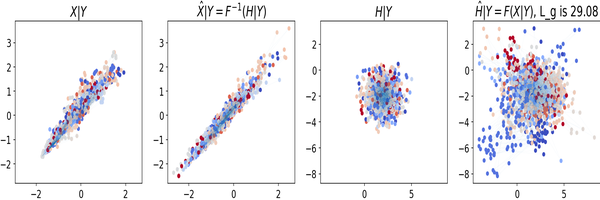
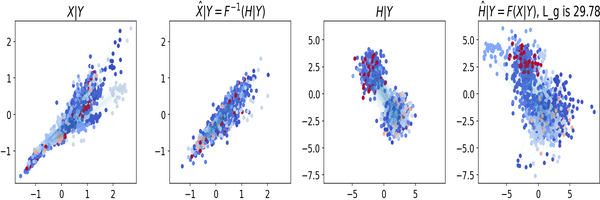
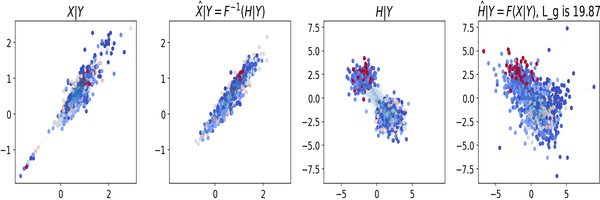

In [ ]:
# View images one by one, but work after refreshing
Num = range(1,4)
version = 'four_FC'
iter = real_data_trainer.epochs
loss_images = {f'Loss': media.read_image(f'ATD_traffic_{version}/Losses_epoch{iter}.png') for i in Num}
gen_images = {f'Train Generation for top {i}': media.read_image(f'ATD_traffic_{version}/Generation_train_epoch{iter}_top{i}_occurrences.png') for i in Num}
gen_images_test = {f'Test Generation for top {i}': media.read_image(f'ATD_traffic_{version}/Generation_test_epoch{iter}_top{i}_occurrences.png') for i in Num}
media.show_images(loss_images,height=600,width=300, columns = 2)
media.show_images(gen_images,height=200,width=600, columns = 3)
media.show_images(gen_images_test,height=200,width=600, columns = 3)

## CINN-MMD or CINN-Nflow

In [ ]:
for _ in ['Training_CINN']:
    edge_index = None
    models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test = get_training_input(
        'real_traffic_ATD', 'three_FC', edge_index, X_train, Y_train, X_test, Y_test)
    # for CINN_obj in ['', '_Nflow']:
    for CINN_obj in ['_Nflow']:
        ########## CINN here ##########
        if 'Nflow' in CINN_obj:
            dim, nblocks, clamp_val, lr = 64, 40, 0.25, 1e-4
        else:
            dim, nblocks, clamp_val, lr = 64, 40, 0.25, 1e-4
        def subnet_fc(c_in, c_out):
            return nn.Sequential(nn.Linear(c_in, dim), nn.ELU(), nn.Linear(dim,  dim), nn.ELU(),
                                nn.Linear(dim,  c_out))
        ndim_x = V*C
        ndim_y = V*Y_dim
        ndim_tot = ndim_x+ndim_y+V*4  # 4 dimension per node for padding
        nodes = [InputNode(ndim_tot, name='input')]
        for k in range(nblocks):
            nodes.append(Node(nodes[-1],
                              GLOWCouplingBlock,
                              {'subnet_constructor': subnet_fc, 'clamp': clamp_val},
                              name=F'coupling_{k}'))
            nodes.append(Node(nodes[-1],
                              PermuteRandom,
                              {'seed': k},
                              name=F'permute_{k}'))
        nodes.append(OutputNode(nodes[-1], name='output'))
        model = ReversibleGraphNet(nodes, verbose=False).to(device)
        l2_reg = 2e-5
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.8, 0.9),
                                    eps=1e-6, weight_decay=l2_reg)
        models[0] = [model]
        train_args[0] = optimizer
        ########## CINN end ##########
        train_args[-1] = False  # If resume_training
        train_args[-3] = 500  # Num epochs
        real_data_trainer = utils.IResNet_training_on_graph(
            models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
        real_data_trainer.CINN_obj = CINN_obj
        real_data_trainer.stop_criterion = 1e-7
        real_data_trainer.data_name += real_data_trainer.CINN_obj
        real_data_trainer.ndim_x, real_data_trainer.ndim_y, real_data_trainer.ndim_tot = ndim_x, ndim_y, ndim_tot
        real_data_trainer.all_together_competitor()

In [ ]:
for _ in ['Load_and_visualize']:
    epoch_ls = []
    for CINN_obj in ['', '_Nflow']:
        real_data_trainer = utils.IResNet_training_on_graph(
            models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
        real_data_trainer.CINN_obj = CINN_obj  # Nflow or '', which denotes MMD
        real_data_trainer.data_name += real_data_trainer.CINN_obj
        real_data_trainer.ndim_x, real_data_trainer.ndim_y, real_data_trainer.ndim_tot = ndim_x, ndim_y, ndim_tot
        real_data_trainer.resume_checkpoint = True
        real_data_trainer.final_viz = True
        real_data_trainer.cpu_load = True
        real_data_trainer.load_from_checkpoint_competitors()
        epoch = real_data_trainer.epoch + 1
        epoch_ls.append(epoch)
        real_data_trainer.viz_generation_competitors()
        real_data_trainer.viz_losses_competitors()
        print('########################################################')

""

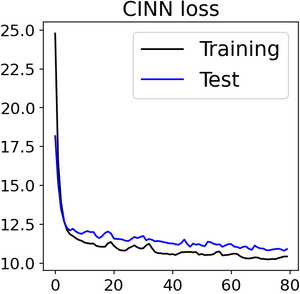

At Train ATD traffic top 1,At Train ATD traffic top 2,At Train ATD traffic top 3

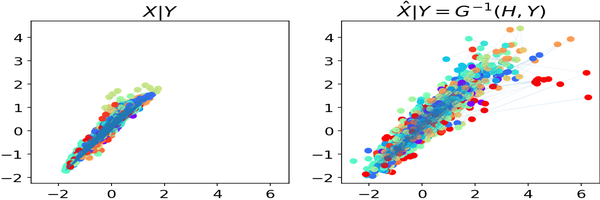
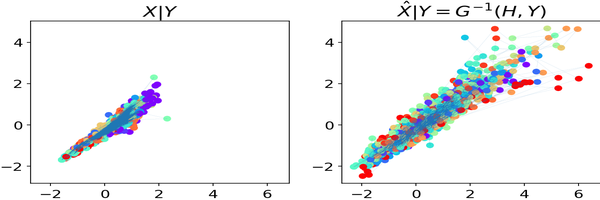
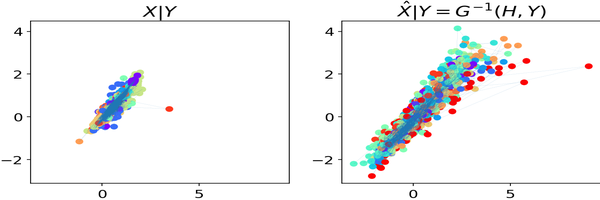

########################################################


""

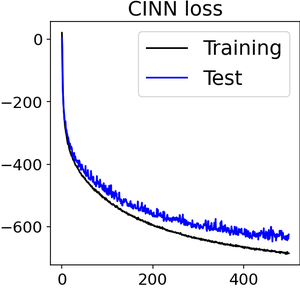

At Train ATD traffic top 1,At Train ATD traffic top 2,At Train ATD traffic top 3

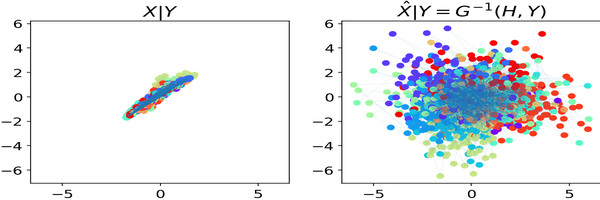
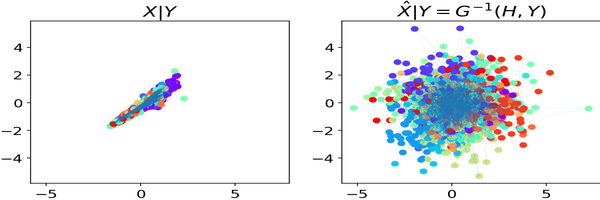
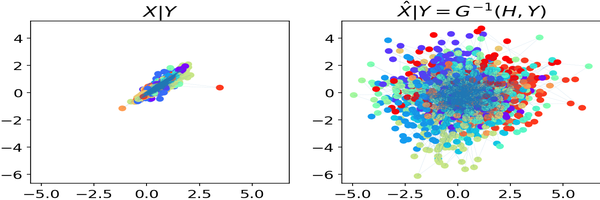

########################################################


In [ ]:
# View images one by one, but work after refreshing
Num = range(1,4)
for i, CINN_obj in enumerate(['', '_Nflow']):
    epoch = epoch_ls[i]
    version, method = 'three_FC', 'CINN'
    media.show_image(media.read_image(f'ATD_traffic_{version}{CINN_obj}_{method}/Losses_epoch{epoch}.png'),width=300)
    loss_images = {f'At Train ATD traffic top {i}': media.read_image(f'ATD_traffic_{version}{CINN_obj}_{method}/Generation_train_epoch{epoch}_top{i}_occurrences.png') for i in Num}
    media.show_images(loss_images,height=200,width=600, columns = 3)
    print('########################################################')

## CGAN 

In [ ]:
version = 'four_FC'
edge_index = None
models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test = get_training_input(
    'real_traffic_ATD', version, edge_index, X_train, Y_train, X_test, Y_test)
########## CGAN HERE ##########
dim = 64
edge_index_tmp = traffic_loader.edge_index.clone()
A_, graph = None, True
if 'L3' in version or 'Cheb' not in version:
    A_ = pyg.utils.to_dense_adj(edge_index_tmp)[0].to(device)
    graph = False
nblocks = 20
net_D = nets.CGAN_net(C+Y_dim, dim, Y_dim, nblocks, True, graph,
                      version=version, A_=A_).to(device)
nblocks = 40
net_G = nets.CGAN_net(C+Y_dim, dim, Y_dim, nblocks, False, graph, version=version, A_=A_).to(device)
optimizer_D = torch.optim.Adam(net_D.parameters(), lr=1e-3, weight_decay = 0.5)
# Small LR makes this almost flat.
optimizer_G = torch.optim.Adam(net_G.parameters(), lr=1e-1, weight_decay = 0.5) 
models[0] = [net_D, net_G]
train_args[0] = [optimizer_D, optimizer_G]
########## CGAN END ##########
train_args[-1] = True  # If resume_training
train_args[-3] = 500  # Num epochs
data_args[-3] = f'ATD_traffic_{version}'
real_data_trainer = utils.IResNet_training_on_graph(
    models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
real_data_trainer.stop_criterion = 1e-6
real_data_trainer.all_together_competitor()

In [ ]:
real_data_trainer = utils.IResNet_training_on_graph(
        models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
real_data_trainer.resume_checkpoint = True
real_data_trainer.load_from_checkpoint_competitors()
real_data_trainer.final_viz = True
epoch = real_data_trainer.epoch + 1
real_data_trainer.viz_generation_competitors()
real_data_trainer.viz_losses_competitors()
real_data_trainer.viz_generation_competitors(viz_train=False)

""

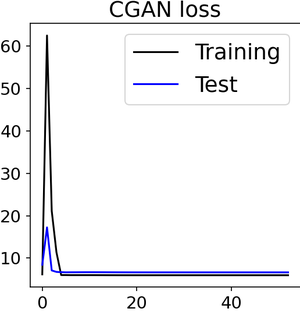

In [ ]:
# View images one by one, but work after refreshing
Num = range(1,4)
version, method = 'four_FC', 'CGAN'
media.show_image(media.read_image(f'ATD_traffic_{version}_{method}/Losses_epoch{epoch}.png'),width=300)
# loss_images = {f'At Train ATD traffic top {i}': media.read_image(f'ATD_traffic_{version}_{method}/Generation_train_epoch{epoch}_top{i}_occurrences.png') for i in Num}
# media.show_images(loss_images,height=200,width=600, columns = 3)

# Two-sample testing

In [ ]:
datasets = ['Solar', 'Traffic']
datasets = ['Traffic']
datasets = ['Solar']
overleaf_path = ''
viz_train = True # True or False. On real-data, always true because test data has dist. shift.
full_res_dict = {}
for dataname in datasets:
    if dataname == 'Solar':
        para_dict = {'CA': [10, 2, 150, 300, 1]}
        city = 'CA'
        V, C, batch_size, epochs, F_out = para_dict[city]
        output_dim, Y_dim, nblocks = 1, 2, 40
        model_args = [0.9, 64, 3]
        solar_loader = utils_data.solar_data(num_obs_per_day=2, city=city)
        solar_loader.get_solar()
        # # If we want to plot
        solar_loader.plot_solar()
        X_train, Y_train, X_test, Y_test, edge_index = solar_loader.X_train, solar_loader.Y_train, solar_loader.X_test, solar_loader.Y_test, solar_loader.edge_index
    else:
        V, C, batch_size, epochs, F_out = 15, 2, 200, 300, 1
        output_dim, Y_dim, nblocks = 1, 2, 40
        model_args = [0.9, 64, 3]
        traffic_loader = utils_data.trffic_data(d=C)
        traffic_loader.get_traffic_train_test(sub=True)
        # Only select a subset for training (e.g., fix Y)
        Unique_Y, counts_Y = torch.unique(
            traffic_loader.Y_train, return_counts=True, dim=0)
        counts_Y, idx = torch.sort(counts_Y, descending=True)
        Unique_Y = Unique_Y[idx]
        Y_rows = None
        # Y_rows = [Unique_Y[1]]
        traffic_loader.select_Y(Y_rows, train=True)
        traffic_loader.select_Y(Y_rows, train=False)
        X_train, X_test, Y_train, Y_test, edge_index = traffic_loader.X_train_sub, traffic_loader.X_test_sub, traffic_loader.Y_train_sub, traffic_loader.Y_test_sub, traffic_loader.edge_index
    save_table = False # Default True
    prefices = ['L3', 'Cheb', 'CINN', 'CINN_Nflow','CGAN', 'FC']
    prefices = ['L3', 'FC'] if dataname == 'Solar' else ['CINN', 'FC'] 
    datafolder = 'real_CA_solar' if dataname == 'Solar' else 'real_traffic_ATD'
    two_sample_stat_dict = {}
    for prefix in prefices:
        if dataname == 'Traffic' and prefix in ['Cheb', 'L3']:
            continue
        CINN_obj = prefix[4:]
        gen_mtd = prefix
        prefix = overleaf_path+dataname+'_'+prefix+'_'
        if 'Cheb' in prefix:
            edge_index = solar_loader.edge_index
            models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test = get_training_input(
                datafolder, 'one_Cheb_two_FC', edge_index, X_train, Y_train, X_test, Y_test)
            train_args[-1] = False  # If resume_training
            real_data_trainer = utils.IResNet_training_on_graph(
                models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
        if 'L3' in prefix:
            edge_index = None
            models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test = get_training_input(
                datafolder, 'one_L3_two_FC', edge_index, X_train, Y_train, X_test, Y_test)
            train_args[-1] = False  # If resume_training
            real_data_trainer = utils.IResNet_training_on_graph(
                models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
            # real_data_trainer.all_together()
        if 'FC' in prefix:
            V, C = 1, 20
            if dataname == 'Traffic':
                C = 30
            X_train = X_train.reshape(X_train.shape[0], V, C)
            X_test = X_test.reshape(X_test.shape[0], V, C)
            edge_index = None
            version = 'three_FC' if dataname == 'Solar' else 'four_FC'
            models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test = get_training_input(
                datafolder, version, edge_index, X_train, Y_train, X_test, Y_test)
            train_args[-1] = True  # If resume_training
            real_data_trainer = utils.IResNet_training_on_graph(
                models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
            # real_data_trainer.all_together()
        if 'CGAN' in prefix:
            version = 'one_Cheb_two_FC' if dataname == 'Solar' else 'four_FC'
            if dataname == 'Traffic':
                edge_index = None
                edge_index_tmp = traffic_loader.edge_index

            else:
                edge_index = solar_loader.edge_index
                edge_index_tmp = solar_loader.edge_index
            models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test = get_training_input(
                datafolder, version, edge_index, X_train, Y_train, X_test, Y_test)
            ########## CGAN HERE ##########
            dim = 64
            A_, graph = None, True
            if 'L3' in version or 'Cheb' not in version:
                A_ = pyg.utils.to_dense_adj(edge_index_tmp)[0].to(device)
                graph = False
            nblocks = 20
            net_D = nets.CGAN_net(C+Y_dim, dim, Y_dim, nblocks, True, graph,
                                  version=version, A_=A_).to(device)
            nblocks = 40
            net_G = nets.CGAN_net(C+Y_dim, dim, Y_dim, nblocks, False,
                                  graph, version=version, A_=A_).to(device)
            optimizer_D = torch.optim.Adam(
                net_D.parameters(), lr=1e-4, weight_decay=0.5)
            optimizer_G = torch.optim.Adam(
                net_G.parameters(), lr=5e-4, weight_decay=0.5)
            models[0] = [net_D, net_G]
            train_args[0] = [optimizer_D, optimizer_G]
            ########## CGAN END ##########
            train_args[-1] = False  # If resume_training
            train_args[-3] = 500  # Num epochs
            real_data_trainer = utils.IResNet_training_on_graph(
                models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
            # real_data_trainer.all_together_competitor()
        if 'CINN' in prefix:
            edge_index = None
            models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test = get_training_input(
                datafolder, 'three_FC', edge_index, X_train, Y_train, X_test, Y_test)
            ########## CINN here ##########
            if 'Nflow' in CINN_obj:
                dim, nblocks, clamp_val, lr = 64, 40, 0.1, 1e-4
            else:
                dim, nblocks, clamp_val, lr = 64, 40, 0.1, 1e-4
            # model = nets.stacked_NVP(d=V*C, c=V*Y_dim, hidden=dim,
            #                          num_b=nblocks, version='four_FC').to(device)

            def subnet_fc(c_in, c_out):
                return nn.Sequential(nn.Linear(c_in, dim), nn.ELU(), nn.Linear(dim,  dim), nn.ELU(),
                                     nn.Linear(dim,  c_out))
            ndim_x = V*C
            ndim_y = V*Y_dim
            ndim_tot = ndim_x+ndim_y+V*4  # 4 dimension per node for padding
            nodes = [InputNode(ndim_tot, name='input')]
            for k in range(nblocks):
                nodes.append(Node(nodes[-1],
                                  GLOWCouplingBlock,
                                  # Was 2.0 when dim == 512 and nblocks = 5
                                  {'subnet_constructor': subnet_fc,
                                      'clamp': clamp_val},
                                  name=F'coupling_{k}'))
                nodes.append(Node(nodes[-1],
                                  PermuteRandom,
                                  {'seed': k},
                                  name=F'permute_{k}'))
            nodes.append(OutputNode(nodes[-1], name='output'))
            model = ReversibleGraphNet(nodes, verbose=False).to(device)
            l2_reg = 2e-5
            optimizer = torch.optim.Adam(
                model.parameters(), lr=lr, weight_decay=l2_reg)
            models[0] = [model]
            train_args[0] = optimizer
            ########## CINN end ##########
            train_args[-1] = False  # If resume_training
            train_args[-3] = 500  # Num epochs
            real_data_trainer = utils.IResNet_training_on_graph(
                models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
            real_data_trainer.ndim_x, real_data_trainer.ndim_y, real_data_trainer.ndim_tot = ndim_x, ndim_y, ndim_tot
            # real_data_trainer.all_together_competitor()
        # Visualization
        ndim_x = V*C
        ndim_y = V*Y_dim
        ndim_tot = ndim_x+ndim_y+V*4  # 4 dimension per node for padding
        train_args[-1] = True  # If resume_training
        real_data_trainer = utils.IResNet_training_on_graph(
            models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
        real_data_trainer.CINN_obj = CINN_obj
        real_data_trainer.data_name += real_data_trainer.CINN_obj
        real_data_trainer.ndim_x, real_data_trainer.ndim_y, real_data_trainer.ndim_tot = ndim_x, ndim_y, ndim_tot
        real_data_trainer.prefix = prefix
        real_data_trainer.cpu_load = True
        if 'CGAN' in prefix or 'CINN' in prefix:
            real_data_trainer.load_from_checkpoint_competitors()
            real_data_trainer.final_viz = True
            real_data_trainer.viz_generation_competitors(viz_train = viz_train)
            real_data_trainer.viz_losses_competitors()
            # real_data_trainer.viz_generation_competitors(viz_train=False)
        else:
            real_data_trainer.load_from_checkpoint()  # Load previous models from file
            real_data_trainer.get_H_cond_Y()  # Get H|Y
            real_data_trainer.viz = True  # If report transport cost
            real_data_trainer.final_viz = True
            real_data_trainer.plot_sub = False # To plot X, \hat X, H, \hat H
            real_data_trainer.viz_generation(viz_train = viz_train)
            real_data_trainer.viz_losses()
        if gen_mtd == 'CINN':
            gen_mtd = 'CINN: MMD'
        if gen_mtd == 'CINN_Nflow':
            gen_mtd = 'CINN: Nflow'
        if gen_mtd in ['L3','Cheb','FC']:
            gen_mtd = f'Ours: {gen_mtd}'
        two_sample_stat_dict[gen_mtd] = real_data_trainer.two_sample_stat
    full_res_dict[dataname] = utils.get_stat_frame_from_dict(two_sample_stat_dict)
if save_table and len(full_res_dict) > 1:
    # Both datasets included
    suff = '_test' if viz_train == False else ''
    torch.save(full_res_dict,f'Real_data_metrics{suff}')

## Train result

In [ ]:
viz_train = True
suff = '_test' if viz_train == False else ''
full_res_dict = torch.load(f'Real_data_metrics{suff}')

In [ ]:
solar_res = full_res_dict['Solar']
solar_res[0]

,MMD: alpha=0.1,MMD: alpha=1.0,MMD: alpha=5.0,MMD: alpha=10.0,Energy
Ours: L3,0.048,0.040,0.011,0.005,0.246
Ours: Cheb,0.053,0.037,0.010,0.005,0.257
CGAN,0.453,0.874,0.988,0.997,2.683
CINN: MMD,0.037,0.039,0.011,0.005,0.197
CINN: Nflow,0.348,0.067,0.012,0.005,2.907
Ours: FC,0.049,0.033,0.011,0.005,0.238


In [ ]:
solar_res[1]

gen_method                                                          Ours: L3  \
Ys                                                 two_sample                  
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]... MMD: alpha=0.1      0.015   
                                                   MMD: alpha=1.0      0.162   
                                                   MMD: alpha=5.0      0.335   
                                                   MMD: alpha=10.0     0.014   
                                                   Energy              0.158   
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]... MMD: alpha=0.1      0.040   
                                                   MMD: alpha=1.0      0.004   
                                                   MMD: alpha=5.0      0.047   
                                                   MMD: alpha=10.0     0.009   
                                                   Energy              0.002   
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]... MMD: alpha=0.1      0.021   
                                                   MMD: alpha=1.0      0.004   
                                                   MMD: alpha=5.0      0.076   
                                                   MMD: alpha=10.0     0.789   
                                                   Energy              1.934   

gen_method                                                          Ours: Cheb  \
Ys                                                 two_sample                    
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]... MMD: alpha=0.1        0.041   
                                                   MMD: alpha=1.0        0.081   
                                                   MMD: alpha=5.0        0.231   
                                                   MMD: alpha=10.0       0.019   
                                                   Energy                0.123   
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]... MMD: alpha=0.1        0.038   
                                                   MMD: alpha=1.0        0.004   
                                                   MMD: alpha=5.0        0.041   
                                                   MMD: alpha=10.0       0.009   
                                                   Energy                0.002   
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]... MMD: alpha=0.1        0.020   
                                                   MMD: alpha=1.0        0.004   
                                                   MMD: alpha=5.0        0.189   
                                                   MMD: alpha=10.0       0.387   
                                                   Energy                1.485   

gen_method                                                           CGAN  \
Ys                                                 two_sample               
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]... MMD: alpha=0.1   0.267   
                                                   MMD: alpha=1.0   1.297   
                                                   MMD: alpha=5.0   0.668   
                                                   MMD: alpha=10.0  0.800   
                                                   Energy           1.201   
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]... MMD: alpha=0.1   1.026   
                                                   MMD: alpha=1.0   0.974   
                                                   MMD: alpha=5.0   1.047   
                                                   MMD: alpha=10.0  1.009   
                                                   Energy           0.992   
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]... MMD: alpha=0.1   1.021   
                                                   MMD: alpha=1.0   1.004   
                                                   MMD: alpha=5.0   1.895   
                                                   MMD: alpha=10.0  6.288   
            

In [ ]:
traffic_res = full_res_dict['Traffic']
traffic_res[0]

,MMD: alpha=0.1,MMD: alpha=1.0,MMD: alpha=5.0,MMD: alpha=10.0,Energy
CGAN,0.823,1.052,1.011,1.005,3.856
CINN: MMD,0.140,0.053,0.011,0.005,1.327
CINN: Nflow,0.316,0.055,0.011,0.005,6.487
Ours: FC,0.058,0.037,0.010,0.005,0.214


In [ ]:
traffic_res[1]

gen_method                                                           CGAN  \
Ys                                                 two_sample               
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,... MMD: alpha=0.1   0.823   
                                                   MMD: alpha=1.0   0.608   
                                                   MMD: alpha=5.0   1.086   
                                                   MMD: alpha=10.0  1.053   
                                                   Energy           1.039   
tensor([0., 0., 0., 1., 1., 1., 0., 0., 1., 0.,... MMD: alpha=0.1   1.064   
                                                   MMD: alpha=1.0   1.012   
                                                   MMD: alpha=5.0   1.008   
                                                   MMD: alpha=10.0  1.003   
                                                   Energy           1.006   
tensor([0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,... MMD: alpha=0.1   1.002   
                                                   MMD: alpha=1.0   1.000   
                                                   MMD: alpha=5.0   3.791   
                                                   MMD: alpha=10.0  2.797   
                                                   Energy           5.637   

gen_method                                                          CINN: MMD  \
Ys                                                 two_sample                   
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,... MMD: alpha=0.1       0.102   
                                                   MMD: alpha=1.0       0.209   
                                                   MMD: alpha=5.0       0.330   
                                                   MMD: alpha=10.0      0.053   
                                                   Energy               0.045   
tensor([0., 0., 0., 1., 1., 1., 0., 0., 1., 0.,... MMD: alpha=0.1       0.061   
                                                   MMD: alpha=1.0       0.013   
                                                   MMD: alpha=5.0       0.008   
                                                   MMD: alpha=10.0      0.003   
                                                   Energy               0.006   
tensor([0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,... MMD: alpha=0.1       0.003   
                                                   MMD: alpha=1.0       0.000   
                                                   MMD: alpha=5.0       1.136   
                                                   MMD: alpha=10.0      1.681   
                                                   Energy               2.275   

gen_method                                                          CINN: Nflow  \
Ys                                                 two_sample                     
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,... MMD: alpha=0.1         0.281   
                                                   MMD: alpha=1.0         0.340   
                                                   MMD: alpha=5.0         0.536   
                                                   MMD: alpha=10.0        0.055   
                                                   Energy                 0.046   
tensor([0., 0., 0., 1., 1., 1., 0., 0., 1., 0.,... MMD: alpha=0.1         0.064   
                                                   MMD: alpha=1.0         0.013   
                                                   MMD: alpha=5.0         0.008   
                                                   MMD: alpha=10.0        0.003   
                                                   Energy                 0.006   
tensor([0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,... MMD: alpha=0.1         0.003   
                                                   MMD: alpha=1.0         0.000   
                                                   MMD: alpha=5.0         6.567   
                                                   MMD: alpha=10.0 

## Test result 

In [ ]:
viz_train = False
suff = '_test' if viz_train == False else ''
full_res_dict = torch.load(f'Real_data_metrics{suff}')

In [ ]:
solar_res = full_res_dict['Solar']
solar_res[0]

,MMD: alpha=0.1,MMD: alpha=1.0,MMD: alpha=5.0,MMD: alpha=10.0,Energy
Ours: L3,0.078,0.066,0.014,0.006,0.474
Ours: Cheb,0.062,0.063,0.014,0.006,0.341
CGAN,0.572,0.938,0.997,1.000,3.422
CINN: MMD,0.061,0.056,0.014,0.006,0.344
CINN: Nflow,0.402,0.091,0.015,0.006,3.488
Ours: FC,0.058,0.060,0.014,0.006,0.295


In [ ]:
solar_res[1]

gen_method                                                          Ours: L3  \
Ys                                                 two_sample                  
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]... MMD: alpha=0.1      0.018   
                                                   MMD: alpha=1.0      0.234   
                                                   MMD: alpha=5.0      0.489   
                                                   MMD: alpha=10.0     0.010   
                                                   Energy              0.228   
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]... MMD: alpha=0.1      0.342   
                                                   MMD: alpha=1.0      0.002   
                                                   MMD: alpha=5.0      0.050   
                                                   MMD: alpha=10.0     0.066   
                                                   Energy              0.001   
tensor([1., 0., 1., 1., 1., 1., 1., 1., 1., 1.]... MMD: alpha=0.1      0.021   
                                                   MMD: alpha=1.0      0.025   
                                                   MMD: alpha=5.0      0.193   
                                                   MMD: alpha=10.0     1.195   
                                                   Energy              2.458   

gen_method                                                          Ours: Cheb  \
Ys                                                 two_sample                    
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]... MMD: alpha=0.1        0.029   
                                                   MMD: alpha=1.0        0.150   
                                                   MMD: alpha=5.0        0.281   
                                                   MMD: alpha=10.0       0.013   
                                                   Energy                0.207   
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]... MMD: alpha=0.1        0.311   
                                                   MMD: alpha=1.0        0.002   
                                                   MMD: alpha=5.0        0.048   
                                                   MMD: alpha=10.0       0.066   
                                                   Energy                0.001   
tensor([1., 0., 1., 1., 1., 1., 1., 1., 1., 1.]... MMD: alpha=0.1        0.021   
                                                   MMD: alpha=1.0        0.025   
                                                   MMD: alpha=5.0        0.200   
                                                   MMD: alpha=10.0       0.677   
                                                   Energy                1.483   

gen_method                                                           CGAN  \
Ys                                                 two_sample               
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]... MMD: alpha=0.1   0.334   
                                                   MMD: alpha=1.0   1.380   
                                                   MMD: alpha=5.0   1.084   
                                                   MMD: alpha=10.0  0.831   
                                                   Energy           1.273   
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]... MMD: alpha=0.1   1.327   
                                                   MMD: alpha=1.0   0.980   
                                                   MMD: alpha=5.0   1.051   
                                                   MMD: alpha=10.0  1.066   
                                                   Energy           0.993   
tensor([1., 0., 1., 1., 1., 1., 1., 1., 1., 1.]... MMD: alpha=0.1   1.021   
                                                   MMD: alpha=1.0   1.025   
                                                   MMD: alpha=5.0   2.422   
                                                   MMD: alpha=10.0  6.877   
            

In [ ]:
traffic_res = full_res_dict['Traffic']
traffic_res[0]

,MMD: alpha=0.1,MMD: alpha=1.0,MMD: alpha=5.0,MMD: alpha=10.0,Energy
CGAN,0.916,1.056,1.008,1.003,4.132
CINN: MMD,0.152,0.056,0.008,0.003,1.484
CINN: Nflow,0.281,0.058,0.008,0.003,6.183
Ours: FC,0.128,0.059,0.008,0.003,0.537


In [ ]:
traffic_res[1]

gen_method                                                           CGAN  \
Ys                                                 two_sample               
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,... MMD: alpha=0.1   0.893   
                                                   MMD: alpha=1.0   0.875   
                                                   MMD: alpha=5.0   1.161   
                                                   MMD: alpha=10.0  1.052   
                                                   Energy           1.072   
tensor([0., 0., 0., 1., 1., 1., 0., 0., 1., 0.,... MMD: alpha=0.1   1.073   
                                                   MMD: alpha=1.0   1.009   
                                                   MMD: alpha=5.0   1.007   
                                                   MMD: alpha=10.0  1.002   
                                                   Energy           1.003   
tensor([0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,... MMD: alpha=0.1   1.001   
                                                   MMD: alpha=1.0   1.000   
                                                   MMD: alpha=5.0   3.922   
                                                   MMD: alpha=10.0  3.939   
                                                   Energy           6.166   

gen_method                                                          CINN: MMD  \
Ys                                                 two_sample                   
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,... MMD: alpha=0.1       0.110   
                                                   MMD: alpha=1.0       0.214   
                                                   MMD: alpha=5.0       0.421   
                                                   MMD: alpha=10.0      0.051   
                                                   Energy               0.074   
tensor([0., 0., 0., 1., 1., 1., 0., 0., 1., 0.,... MMD: alpha=0.1       0.073   
                                                   MMD: alpha=1.0       0.009   
                                                   MMD: alpha=5.0       0.008   
                                                   MMD: alpha=10.0      0.002   
                                                   Energy               0.003   
tensor([0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,... MMD: alpha=0.1       0.002   
                                                   MMD: alpha=1.0       0.000   
                                                   MMD: alpha=5.0       1.164   
                                                   MMD: alpha=10.0      1.535   
                                                   Energy               4.132   

gen_method                                                          CINN: Nflow  \
Ys                                                 two_sample                     
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,... MMD: alpha=0.1         0.247   
                                                   MMD: alpha=1.0         0.316   
                                                   MMD: alpha=5.0         0.518   
                                                   MMD: alpha=10.0        0.053   
                                                   Energy                 0.074   
tensor([0., 0., 0., 1., 1., 1., 0., 0., 1., 0.,... MMD: alpha=0.1         0.073   
                                                   MMD: alpha=1.0         0.009   
                                                   MMD: alpha=5.0         0.008   
                                                   MMD: alpha=10.0        0.002   
                                                   Energy                 0.003   
tensor([0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,... MMD: alpha=0.1         0.002   
                                                   MMD: alpha=1.0         0.000   
                                                   MMD: alpha=5.0         6.191   
                                                   MMD: alpha=10.0 